# AnoGan_on_MVTec_with_bottle_class

### 0. Getting Data

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Projet_IA_2023

In [2]:
!pip install fastai==1.0.61
!pip install jupyter
!pip install matplotlib
!pip install wget
!pip install kornia
!pip install opencv-python


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 22.6 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19171 sha256=ae01d8a70b239b76b17bf4081687ee7b5782a3a2f25543eff493e4ef8709d6f8
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.14
    Uninstalling fastai-2.7.14:
      Successfully uninstalled fastai-2.7.14
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9bdf65bdd29466acbd3eb31b99f6416a767701015cd3dee559d6381c2c94173e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import sys, wget, tarfile, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import kornia
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

We will be using in this colab, the Bottle Class.

In [4]:
data_path=Path("/kaggle/input/bottle")
dset='bottle'

In [5]:
list((data_path/dset/'train').glob('*'))
im_paths=list((data_path/dset/'train'/'good').glob('*'))
len(im_paths) #How many examples do we have? (We have 209 images for the train)

209

In [6]:
# The test folder has a bit more going on, and includes examples of a 3 defect
# classes, and some more good examples to use in testing.
list((data_path/dset/'test').glob('*'))

[PosixPath('/kaggle/input/bottle/bottle/test/good'),
 PosixPath('/kaggle/input/bottle/bottle/test/contamination'),
 PosixPath('/kaggle/input/bottle/bottle/test/broken_large'),
 PosixPath('/kaggle/input/bottle/bottle/test/broken_small')]

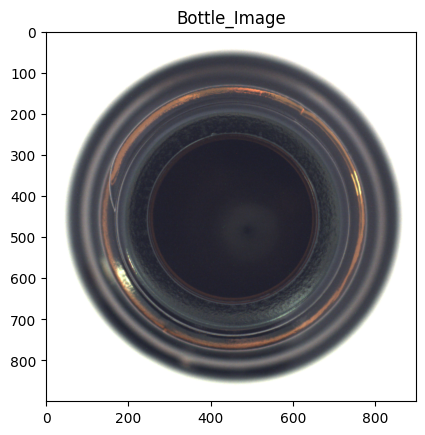

In [7]:
plt.imshow(plt.imread(str(im_paths[0])))
plt.title('Bottle_Image');

Now, we'll create a a dataloader that will return minibatches of size 128, downsample our images to 64x64. The databunch from the fastai library will take care of data augmentation and normalization.

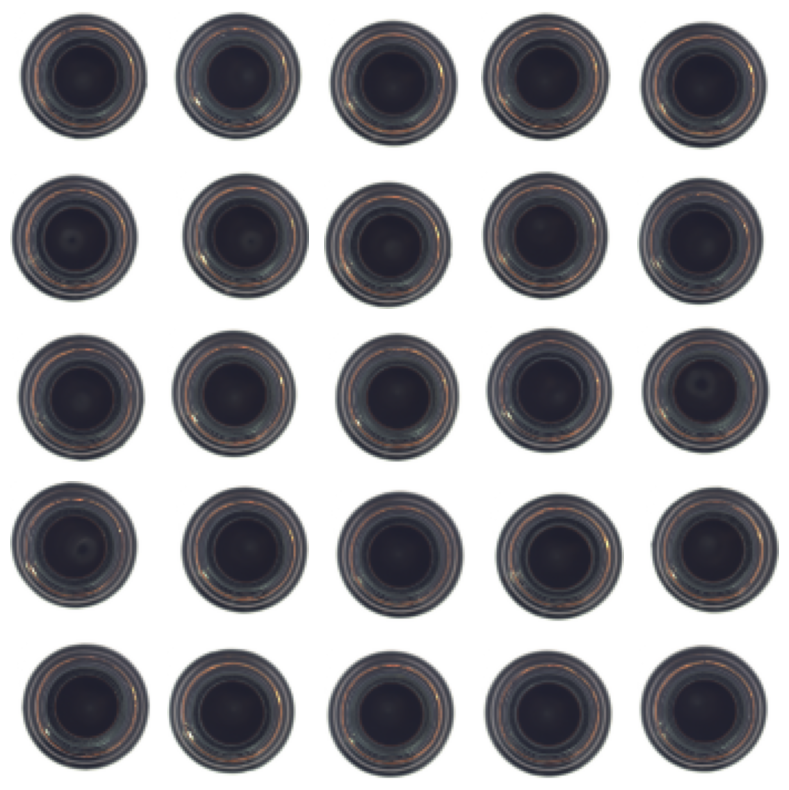

In [8]:
batch_size, im_size, channels = 64, 64, 3
tfms = ([*rand_pad(padding=3, size=im_size, mode='border')], [])
data = ImageList.from_folder(data_path/dset/'train'/'good').split_none() \
                                                                .label_empty() \
                                                                .transform(tfms, size=im_size) \
                                                                .databunch(bs=batch_size) \
                                                                .normalize((0.5, 0.5))

data.show_batch(figsize=(8, 8))

Let's have a quick look at the scale of the data.

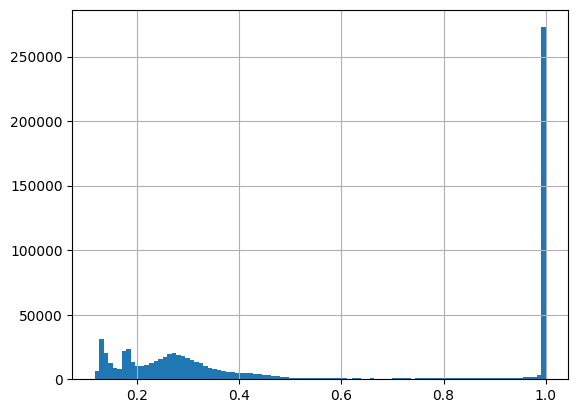

In [9]:
# Our GAN needs to learn to imitate this distribution.

x, y=data.one_batch()
plt.hist(x.numpy().ravel(),100); plt.grid(1)

### 1. Creating Models

In [10]:
import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #Do we have a GPU?
defaults.device = device
print(device)

cuda


In [11]:
def conv_trans(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding),
        nn.BatchNorm2d(nf),
        nn.ReLU(inplace = True))

In [12]:
G = nn.Sequential(
    conv_trans(100, 1024, ks=4, stride=1, padding=0),
    conv_trans(1024, 512),
    conv_trans(512, 256),
    conv_trans(256, 128),
    nn.ConvTranspose2d(128, channels, 4, stride=2, padding=1),
    nn.Tanh()).to(device)

Let's test our Generator by creating a random vector and passing to the Generator!

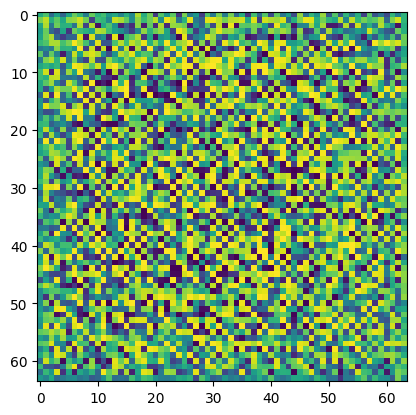

In [13]:
z = torch.randn(1, 100, 1, 1)
fake = G(z.to(device))
plt.imshow(fake[0, 0].cpu().detach().numpy()); plt.grid(0)

Now, let's create the Discriminator.

In [14]:
def conv(ni, nf, ks=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=padding),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(0.2, inplace = True))

In [15]:
D = nn.Sequential(
    conv(channels, 128),
    conv(128, 256),
    conv(256, 512),
    conv(512, 1024),
    nn.Conv2d(1024, 1, 4, stride=1, padding=0),
    Flatten(),
    nn.Sigmoid()).to(device)

Let's try the Generator and the Discriminator!

In [16]:
fake=G(z.to(device))
D(fake)

tensor([[0.5618]], device='cuda:0', grad_fn=<SigmoidBackward0>)

The result we got, is the probability that the fake image is real.

For the training, we'll be passing in both real and fake data into our discriminator.

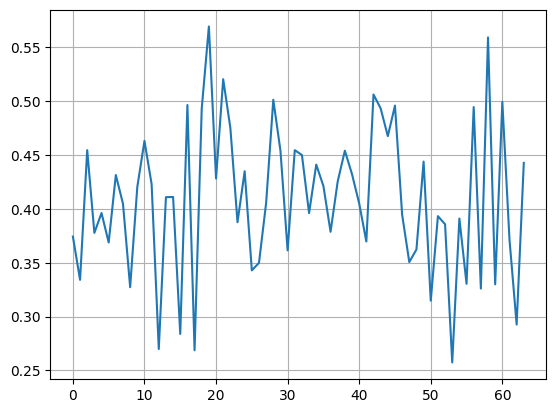

In [17]:
x,y=data.one_batch()
out=D(x.to(device))
plt.plot(out.detach().cpu()); plt.grid(1)

The outputs we've plotted are the probabilities of being real the discriminator has assigned to each image.

The results are wrong because we didn't train the discriminator yet.

### 2. Training

First, we'll choose randomly 25 points in our latent space. At each visualization step, we'll pass these 25 points through our generator, and see how our fake images look. As we train, our random noise should start to be shaped into hazelnuts!

Secondly, we'll plot a histogram of the pixel intensity of our fake images G(z) and compare these to our histograms of the pixel intensity values in our real images x. As we train, these distributions should look more and more similar.

In [18]:
from torch import optim
from tqdm import tqdm
from IPython import display
import matplotlib.gridspec as gridspec

save_training_viz=True
save_dir=Path('/kaggle/working/exports') #Location to save training visualzations
(save_dir/'viz').mkdir(exist_ok=True, parents=True)
(save_dir/'ckpts').mkdir(exist_ok=True, parents=True)

In [19]:
def show_progress(save=False):
    '''Visualization method to see how were doing'''
    plt.clf(); fig=plt.figure(0, (24, 12)); gs=gridspec.GridSpec(6, 12)
    with torch.no_grad(): fake=G(z_fixed)
    for j in range(30):
        fig.add_subplot(gs[(j//6), j%6])
        plt.imshow((kornia.tensor_to_image(fake[j])+1)/2); plt.axis('off')
    ax=fig.add_subplot(gs[5, :4]); plt.hist(fake.detach().cpu().numpy().ravel(), 100, facecolor='xkcd:crimson')
    ax.get_yaxis().set_ticks([]); plt.xlabel('$G(z)$', fontsize=16); plt.xlim([-1, 1])
    ax=fig.add_subplot(gs[5, 4:7]); plt.hist(x.cpu().numpy().ravel(), 100, facecolor='xkcd:purple')
    ax.get_yaxis().set_ticks([]); plt.xlabel('$x$', fontsize=16)
    fig.add_subplot(gs[:,7:])
    plt.plot(losses[0], color='xkcd:goldenrod', linewidth=2); plt.plot(losses[1], color='xkcd:sea blue', linewidth=2);
    plt.legend(['Discriminator', 'Generator'],loc=1, fontsize=16);
    plt.grid(1); plt.title('Epoch = ' + str(epoch), fontsize=16); plt.ylabel('loss', fontsize=16); plt.xlabel('iteration', fontsize=16);
    display.clear_output(wait=True); display.display(plt.gcf())
    if save: plt.savefig(save_dir/'viz'/(str(count)+'.png'), dpi=150)

Now we'll setup our loss function and optimizers following the AnoGan Paper:

In [20]:
optD = optim.Adam(D.parameters(), lr=1e-4, betas = (0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=1e-4, betas = (0.5, 0.999))
criterion = nn.BCELoss()

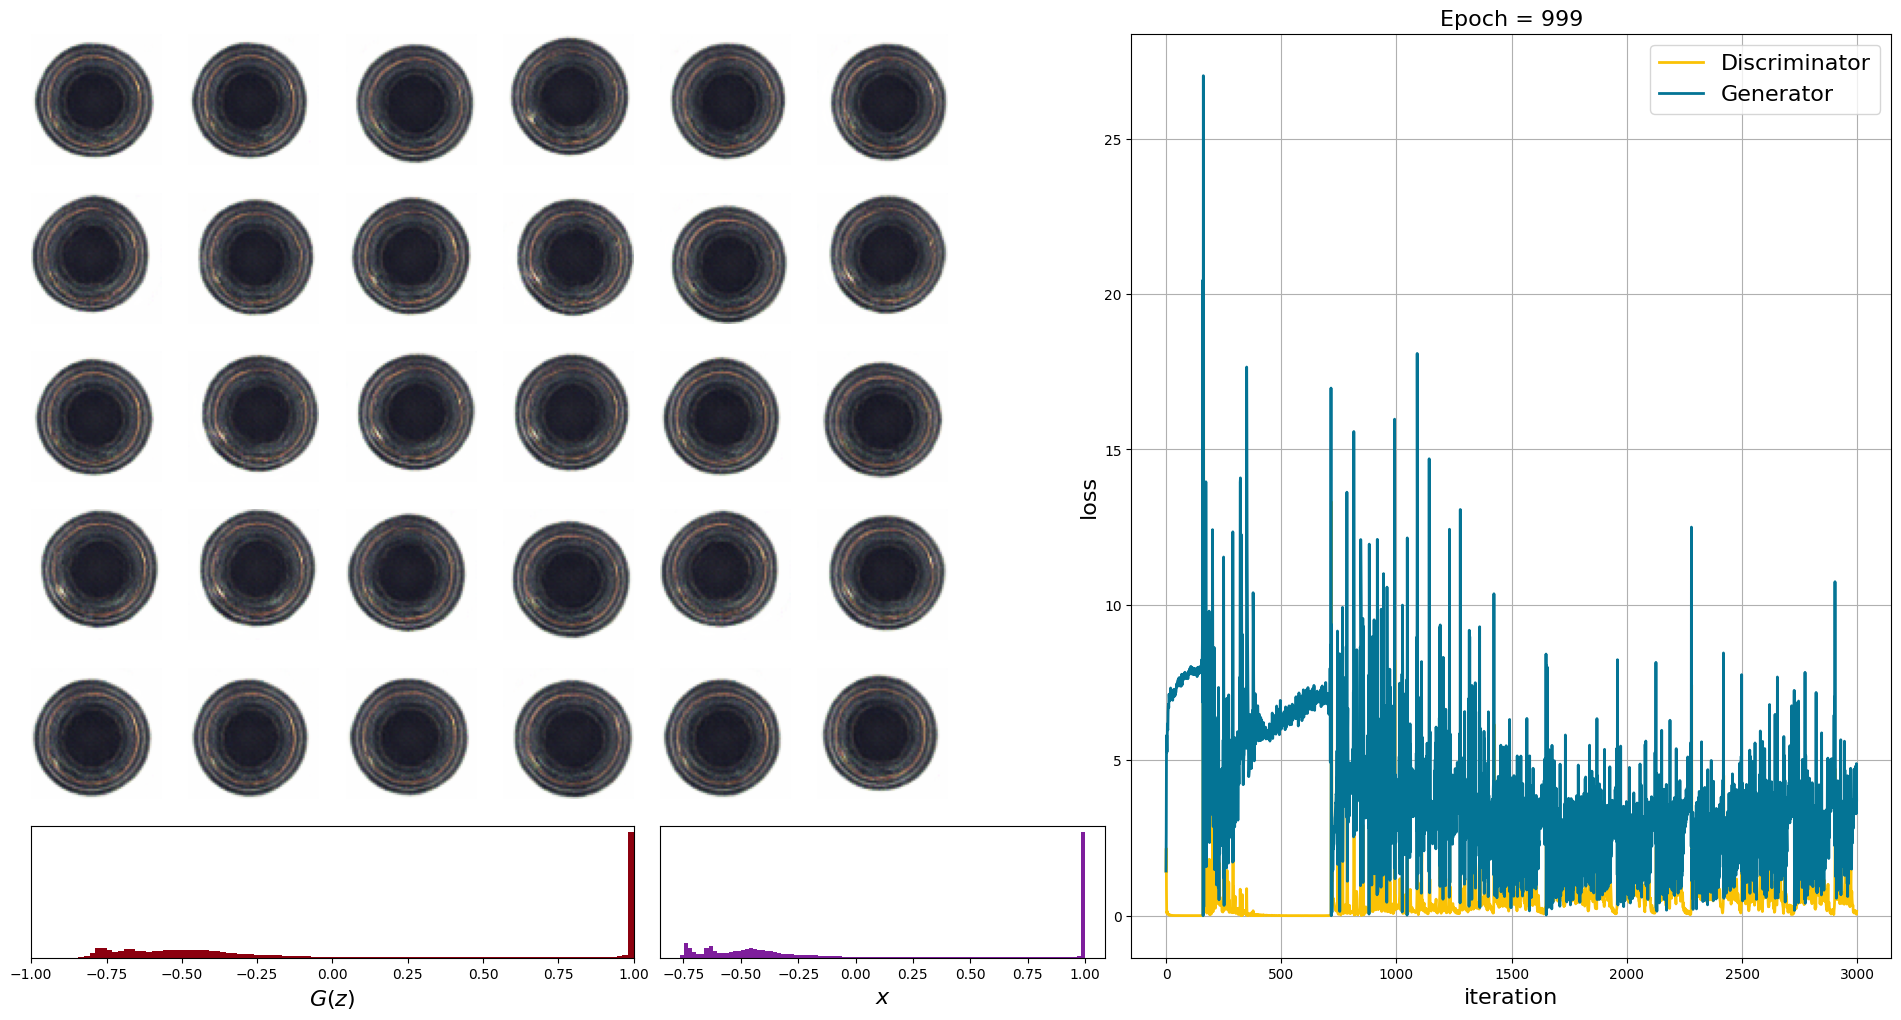

100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


<Figure size 640x480 with 0 Axes>

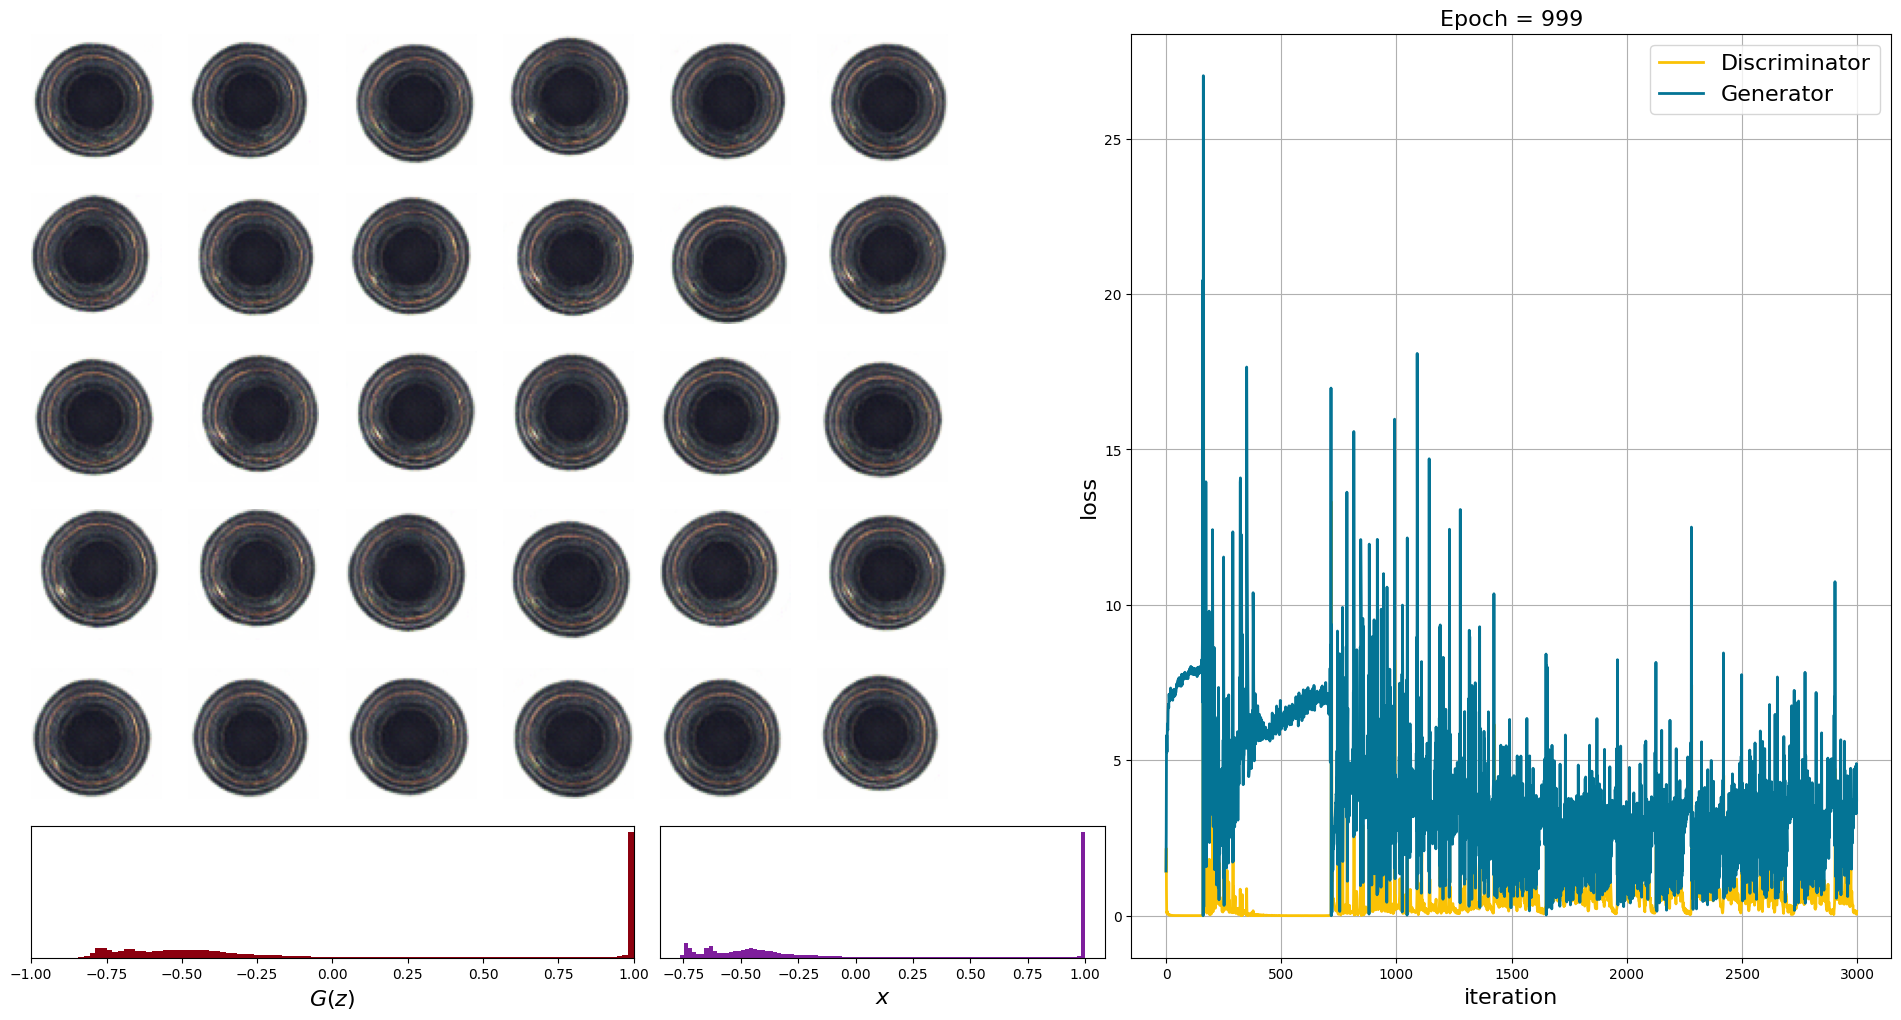

In [21]:
zero_labels = torch.zeros(batch_size).to(device)
ones_labels = torch.ones(batch_size).to(device)
losses = [[],[]]
epochs, viz_freq, save_freq, count = 1000, 100, 500, 0
z_fixed = torch.randn(batch_size, 100, 1, 1).to(device)

for epoch in range(epochs):
    for i, (x,y) in enumerate(tqdm(data.train_dl)):
        #Train Discriminator
        requires_grad(G, False); #Speeds up training a smidge
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        l_fake = criterion(D(G(z)).view(-1), zero_labels)
        l_real = criterion(D(x).view(-1), ones_labels)
        loss = l_fake + l_real
        loss.backward(); losses[0].append(loss.item())
        optD.step(); G.zero_grad(); D.zero_grad();

        #Train Generator
        requires_grad(G, True);
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        loss = criterion(D(G(z)).view(-1), ones_labels)
        loss.backward(); losses[1].append(loss.item())
        optG.step(); G.zero_grad(); D.zero_grad();

        if i%viz_freq==0: show_progress(save_training_viz)
        count+=1
    if (epoch+1)%save_freq==0:
        torch.save(G, save_dir/'ckpts'/('G_epoch_'+str(epoch)+'.pth'))
        torch.save(D, save_dir/'ckpts'/('D_epoch_'+str(epoch)+'.pth'))

### 3. Using the Latent Space

Something interesting to know is that good images represent a manifold in a higher dimensional latent space of all images. This property can be used to detect anomalies!

Given a new image x, we're going to compute the representation of the image in our GANs latent space, and if our image is on the manifold of good iamges, we're going to call it good. And if it's too far from our manifold, we'll call it an anomaly.

But how can we find the representation of a new image in the latent space?

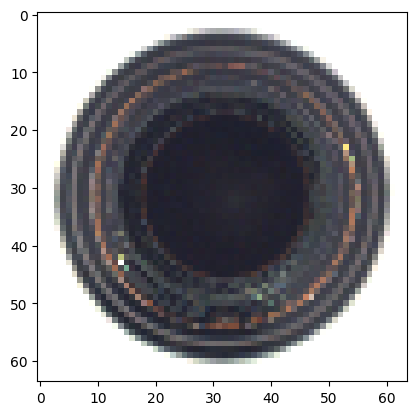

In [22]:
import cv2

im_path=(data_path/dset/'train'/'good').ls()[1]
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
plt.imshow(im)

We would like to know if how for from the manifold of good images in our Generator's latent space this image lies.

Unfortunately, we can't really compute this directly, but we can try to find the nearest point in our Generator's latent space and measure how far away this image is from that point, giving us an idea of how well this image "fits" with our good images.

We can find this nearest neighbor point using a very similar appraoch to our method for training our network. Specifically, we'll pick a random point in latent space, and using gradient descent, walk through latent space from that point guided by gradient descent.

As a loss function, we can use the l1 loss between our generated image and our "query" image.

$$
\mathcal{L}_R(z_\gamma)=\sum |x-G(z_{\gamma})|
$$

Let's give this a shot. We'll pick a random starting point and train for 1000 iterations to reduce the l1 loss between our query image and generated image.

100%|██████████| 1000/1000 [00:05<00:00, 187.96it/s]


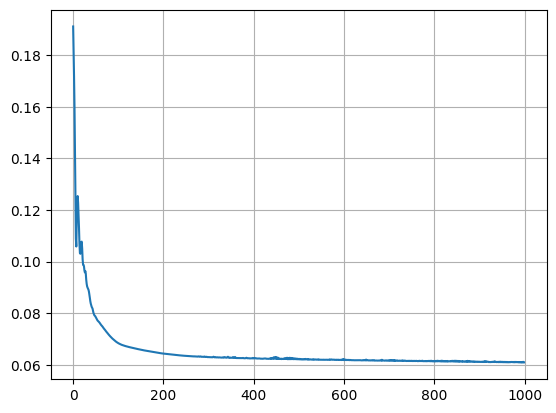

In [23]:
im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device) #Scale image between -1 and +1
z=torch.randn(1, 100, 1, 1, requires_grad=True, device=device) #Random starting point in latent space
opt=optim.Adam([z], lr=2e-2)

losses=[]
for i in tqdm(range(1000)):
    fake=G(z)
    loss=torch.nn.L1Loss()(fake.squeeze(0), im_tensor)
    loss.backward(); opt.step()
    z.grad.zero_(); G.zero_grad()
    losses.append(loss.item())

plt.plot(losses); plt.grid(1)

Text(0.5, 1.0, 'Closest Fake Image')

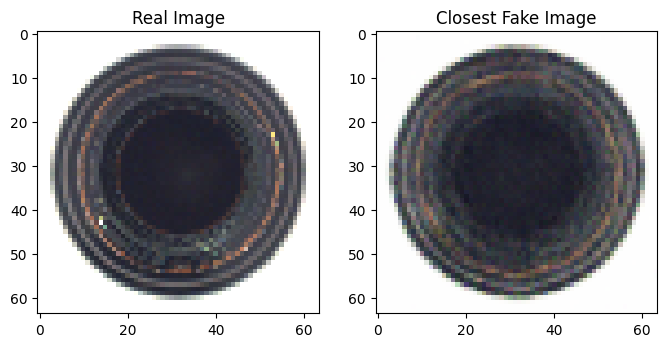

In [24]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(z))+1)/2); plt.title('Closest Fake Image')

The AnoGan authors use one more trick to get better results in finding the closest fake image. As you can imagine, this "optimizing backwards accross our generator" is far from a perfect science. The AnoGAN authors chose to use the discriminator to help the optimization land on a more realistic nearest good image. Specifically, they choose to add a term to the loss function that measures the distance between the discriminator's representation of the real and fake images.

We're going to compare the representation of the real and fake images in the feature space of the discrminator. The idea here is that through the training process the discriminator has learned lots of useful features to measure the perceptual difference between real and fake images. Techniques like this are called **perceptual loss**. The AnoGAN authors again use L1 loss, as shown in the equation below:

$$
\mathcal{L}_D(z_\gamma)=\sum |f(x)-f(G(z_{\gamma}))|
$$

where $f(\cdot)$ represents the intermediate layers of the discriminator.

In [25]:
# Let's create a method that computes the discriminator feature loss loss given a fake image
def get_d_loss(f_x, fake, D):
    loss_d=nn.L1Loss()(f_x[1], D[:1](fake)) #Get loss value from 1st layer of D
    for i in range(2, (len(D)-2)):
        loss_d+=nn.L1Loss()(f_x[i], D[:i](fake)) #And remainig layers of D
    return loss_d

f={} #Precompute feature values for layers
with torch.no_grad():
    for i in range(1, (len(D)-2)): f[i]=D[:i](im_tensor.unsqueeze(0))

Finally, we need to balance our two loss terms (or reconsruction loss and discrminator loss). The AnoGan authors capture this in this equation:

$$
\mathcal{L}(z_\gamma) = (1-\lambda) \cdot \mathcal{L}_R(z_\gamma) + \lambda \cdot \mathcal{L}_D(z_\gamma).
$$

Where $\mathcal{L}(z_\gamma)$ is our overall loss function value, and $\lambda$ conrols the balance between our generator and discriminator loss.

In [26]:
def walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda'):
    f_x={} #Precompute feature values all layers of D
    with torch.no_grad():
        for i in range(1, (len(D)-2)): f_x[i]=D[:i](im_tensor.unsqueeze(0))

    z=torch.randn(1, 100, 1, 1, requires_grad=True, device=device) #random starting point for walk
    opt=optim.Adam([z], lr=lr)

    losses=[]
    for i in tqdm(range(n_iter)):
        fake=G(z) #Get fake image
        loss_r=torch.nn.L1Loss()(fake.squeeze(0), im_tensor) #Residual loss
        loss_d=get_d_loss(f_x, fake, D) #Discrimintator loss
        loss=(1-lambd)*loss_r+lambd*loss_d #Total loss

        loss.backward(); opt.step()
        z.grad.zero_(); G.zero_grad(); D.zero_grad();
        losses.append(loss.item())
    return {'z':z, 'loss':loss.item(), 'loss_r':loss_r.item(), 'loss_d':loss_d.item(), 'losses':losses}

100%|██████████| 1500/1500 [00:17<00:00, 87.92it/s]


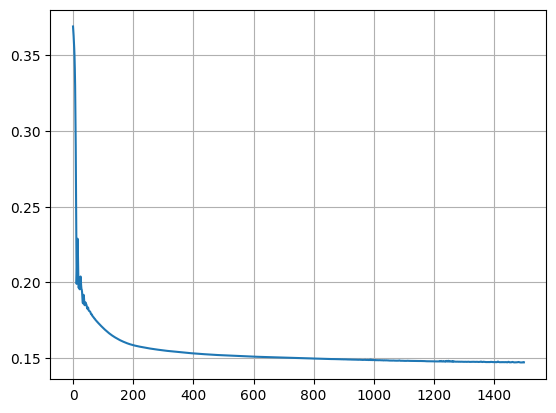

In [27]:
im_path=(data_path/dset/'train'/'good').ls()[1]
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
res=walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda')

# Let's plot the loss.
plt.plot(res['losses']); plt.grid(1)

Finally, let's see the result.

Text(0.5, 1.0, 'Closest Fake Image')

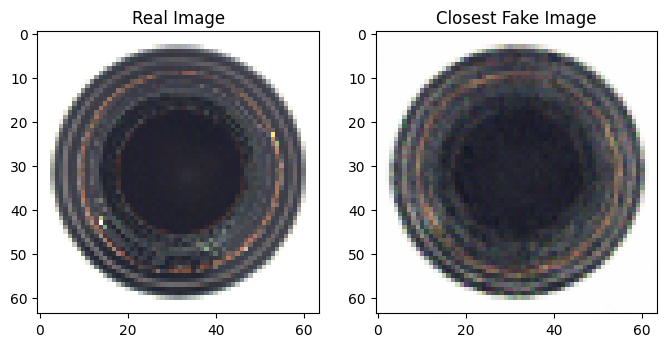

In [28]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Closest Fake Image')

### 4. Finding Anomalies

Now, we finally have all the pieces we need to find anomalies using our GAN. To see how this works, let's grab an image with some anomalies.

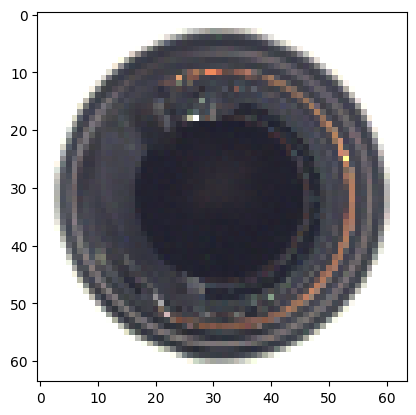

In [ ]:
im_path=Path('/kaggle/input/bottle/bottle/test/broken_large/010.png')
im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
im=cv2.resize(im, (64,64))
plt.imshow(im)

The anogan idea here is that anomalous images like this shouldn't really exist in the latent space of our Generator, since we only trained it on good images. So when we try to reconsturct our anamolous image, the reconstruction should fail.

100%|██████████| 1500/1500 [00:17<00:00, 87.75it/s]


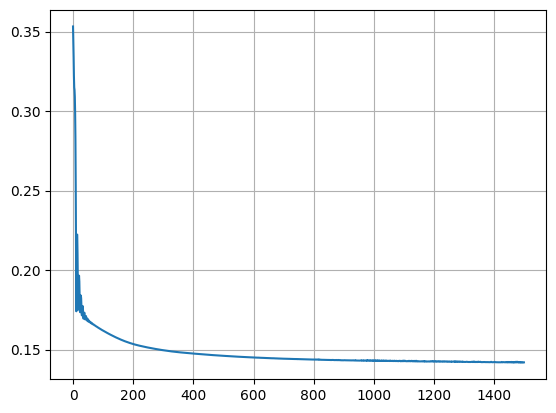

In [ ]:
im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
res=walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda')
plt.plot(res['losses']); plt.grid(1)

Alright, let's have a look at our reconstructed image:

Text(0.5, 1.0, 'Closest Fake Image')

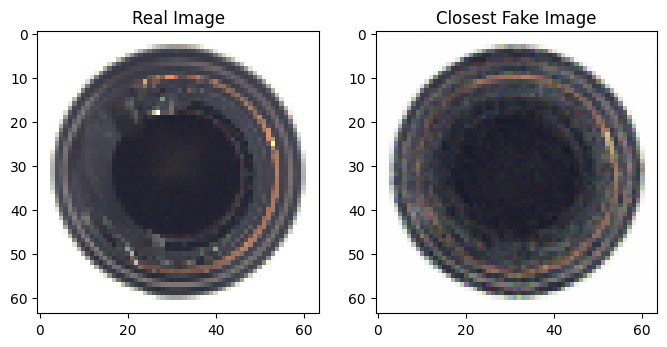

In [ ]:
fig=plt.figure(0, (8,4))
fig.add_subplot(1,2,1)
plt.imshow(im); plt.title('Real Image')

fig.add_subplot(1,2,2)
plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Closest Fake Image')

As we can see, the reconstuction isn't great. The Generator shouldn't be able to reconstruct anomolous images. The idea, now, is to measure how poor the reconsruction is, to measure how anamolous the image is. (We will be setting a certain threshold)

As a metric, it is possible to use the reconsruction loss $\mathcal{L}_R(z_\gamma)$ and the discriminator loss $\mathcal{L}_D(z_\gamma)$. If these losses are high, then we are dealing with an anomalous image.

The AnoGan paper introduced, in addition to this anomaly detection technique, a technique to localize the anomaly. Researchers suggested to compute a residual image (the difference between the original and the reconstructed image) and areas of the residual image with large values should correspond to anomalous regions, since the original and reconstructed image are maxiamlly different in these regions.

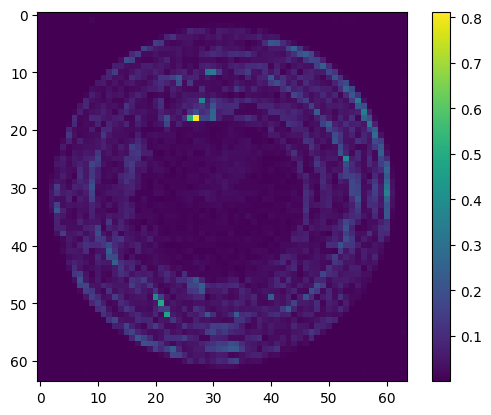

In [ ]:
xr=np.abs((im.astype('float')/255)-(kornia.tensor_to_image(G(z))+1)/2) #Residual image
plt.imshow(np.mean(xr, axis=2))
plt.colorbar()

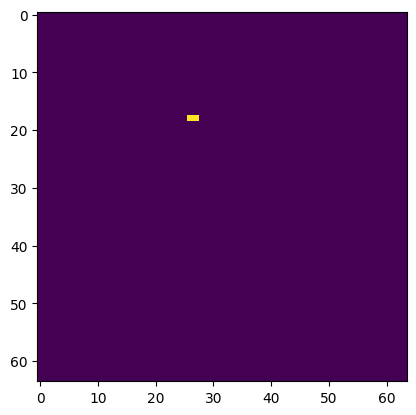

In [ ]:
# Let's identify anomalous pixels

thresh=0.5
plt.imshow(np.mean(xr, axis=2)>thresh)

Text(0.5, 1.0, 'Anomalous Region')

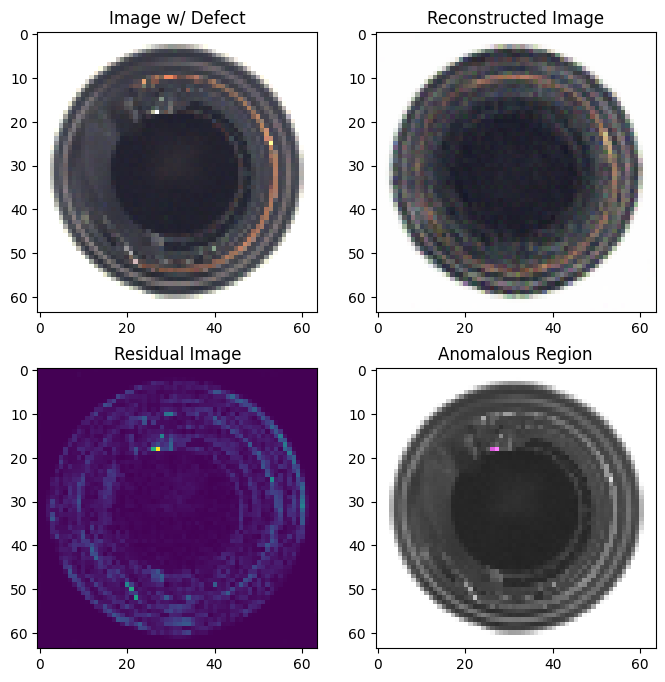

In [ ]:
# As a result, we are getting
im_mask=np.zeros_like(im)
for i in range(3): im_mask[:,:,i]=np.mean(im, axis=2)
im_mask[np.mean(xr, axis=2)>thresh]=im_mask[np.mean(xr, axis=2)>thresh]//2+np.array([255,0,255])//2

fig=plt.figure(0, (8,8))
fig.add_subplot(2,2,1); plt.imshow(im); plt.title('Image w/ Defect')
fig.add_subplot(2,2,2); plt.imshow((kornia.tensor_to_image(G(res['z']))+1)/2); plt.title('Reconstructed Image')
fig.add_subplot(2,2,3); plt.imshow(np.mean(xr, axis=2)); plt.title('Residual Image')
fig.add_subplot(2,2,4); plt.imshow(im_mask); plt.title('Anomalous Region')

Now, let's loop over all of the test images, and for each we'll create a reconstructed image, and compute the reconsruction and discriminator loss for each image.

In [ ]:
params={'n_iter':1500, 'lambd':0.1, 'lr':2e-2}
all_res=[]
im_paths=[p for p in (data_path/dset/'test').glob('*/*.png')]
for im_path in im_paths:
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
    im=cv2.resize(im, (64,64))

    im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
    res=walk_latent_space(G, D, im_tensor, **params, device=device)

    res['im_fake']=(kornia.tensor_to_image(G(res['z']))+1)/2 #Scaled between 0 and 1
    res['im_path']=im_path
    res['label']=im_path.parent.name
    all_res.append(res)

100%|██████████| 1500/1500 [00:16<00:00, 88.52it/s]


Text(0, 0.5, 'Residual Loss')

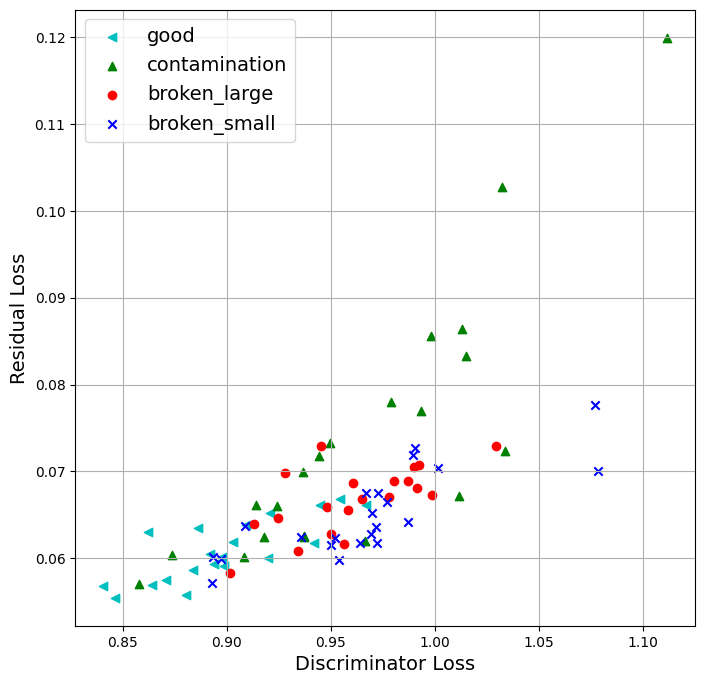

In [ ]:
labels=np.unique([res['label'] for res in all_res])
cm={l:i for i,l in enumerate(labels)}

my_cmap={0:'r', 1:'b', 2:'g', 3:'c', 4:'m', 5:'y'}
my_markers={0:'o', 1:'x', 2:'^', 3:'<', 4:'>', 5:'*'}

fig=plt.figure(0, (8,8))
handles={}
for res in all_res:
    handles[res['label']]=plt.scatter(res['loss_d'], res['loss_r'], c=my_cmap[cm[res['label']]], marker=my_markers[cm[res['label']]])
plt.legend(handles=handles.values(), labels=handles.keys(), fontsize=14); plt.grid(1)
plt.xlabel('Discriminator Loss', fontsize=14)
plt.ylabel('Residual Loss', fontsize=14)

Since the generator should find it more difficult to reproduce anomlous images, we should see a higher reconstruction loss for the anomolous images, relative to the good images. As we can see, this isn't really true, with the good images having medium to high reconsruction losses.

However, we do see a pretty reasonable pattern with our discriminator loss, anomalous images tend to have higher discriminator losses. We can use this to create an anomalous image detector.

Something more complicated that can be done is to classify anomolous images in the space of the discriminator and residual loss using some neural networks.

In [ ]:
def anomaly_detector(im, G, D, d_loss_thresh, r_loss_thresh):
    '''Decides if image im is anomalous'''
    im_tensor=((kornia.image_to_tensor(im).float()/128)-1).to(device)
    res=walk_latent_space(G, D, im_tensor, n_iter=1500, lambd=0.1, lr=2e-2, device='cuda')
    if res['loss_d']>d_loss_thresh or res['loss_r']>r_loss_thresh: return True
    else: return False

Here, we'll choose a d_loss_thresh of 1.3, and a r_loss_thresh value of 0.21.

Let's measure the accuracy of the anomaly detector:

In [ ]:
num_correct=0; total=0 #Measure accuracy on good test examples
for im_path in (data_path/dset/'test'/'good').glob('*.png'):
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
    im=cv2.resize(im, (64,64))
    predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=1.3, r_loss_thresh=0.21)
    if not predicted_anomaly: num_correct+=1
    total+=1
    print(im_path, predicted_anomaly)

100%|██████████| 1500/1500 [00:16<00:00, 88.29it/s]


/kaggle/input/bottle/bottle/test/good/007.png False


100%|██████████| 1500/1500 [00:16<00:00, 88.87it/s]


/kaggle/input/bottle/bottle/test/good/016.png False


100%|██████████| 1500/1500 [00:16<00:00, 88.43it/s]


/kaggle/input/bottle/bottle/test/good/005.png False


100%|██████████| 1500/1500 [00:16<00:00, 88.65it/s]


/kaggle/input/bottle/bottle/test/good/011.png False


100%|██████████| 1500/1500 [00:16<00:00, 88.91it/s]


/kaggle/input/bottle/bottle/test/good/013.png False


100%|██████████| 1500/1500 [00:16<00:00, 88.30it/s]


/kaggle/input/bottle/bottle/test/good/017.png False


100%|██████████| 1500/1500 [00:16<00:00, 88.93it/s]


/kaggle/input/bottle/bottle/test/good/004.png False


 47%|████▋     | 702/1500 [00:07<00:09, 85.96it/s]

In [ ]:
num_correct/total

In [ ]:
num_correct=0; total=0 #Measure accuracy on defective test examples
for im_path in (data_path/dset/'test').glob('*/*'):
    if 'good' in str(im_path): continue
    im=cv2.cvtColor(cv2.imread(str(im_path)), cv2.COLOR_BGR2RGB)
    im=cv2.resize(im, (64,64))
    predicted_anomaly=anomaly_detector(im, G, D, d_loss_thresh=1.3, r_loss_thresh=0.21)
    if predicted_anomaly: num_correct+=1
    total+=1
    print(im_path, predicted_anomaly)

In [ ]:
num_correct/total

For comparison, the MVTec AD paper sites an accruacy on hazelnuts using AnoGAN of 0.83 for the good examples, and 0.16 for the anamolous examples.